### Universidad del Valle de Guatemala<br>Modelación y Simulación<br>Grupo#1

In [1]:
# Se importan las librerías necesarias
from math import inf
import numpy as np
import matplotlib.pyplot as plt
import pygame
import random
import skfuzzy as fuzzy
from PIL import Image

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Definición de variables Crisp y variables lingüísticas para Encontrar la Pelota

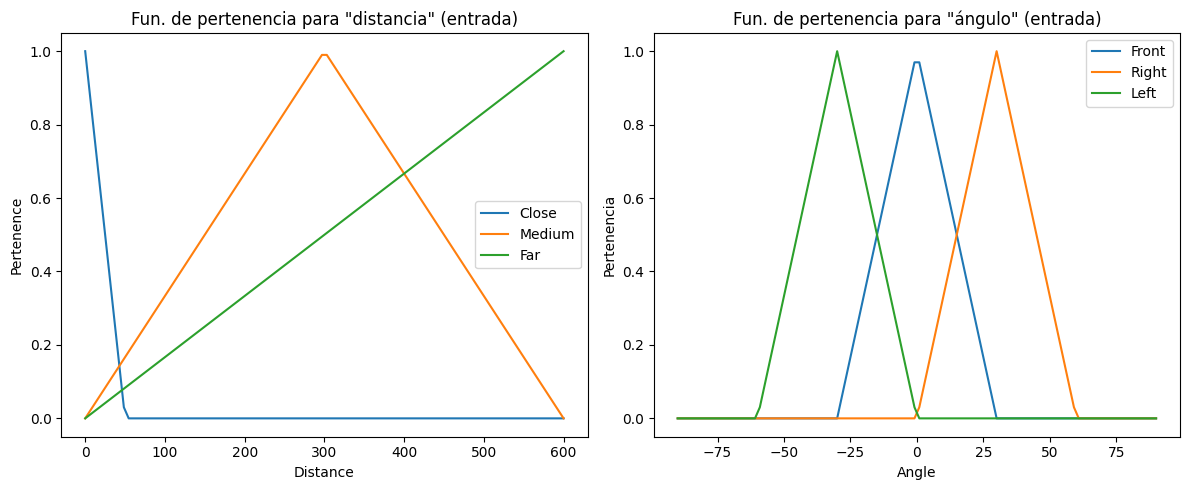

In [2]:
# Definición de funciones de pertenencia para la variable "distancia"
def close_distance(x):
    return np.maximum(0, 1 - abs(x - 0) / 50)

def mid_distance(x):
    return np.maximum(0, 1 - abs(x - 300) / 300)

def far_distance(x):
    return np.maximum(0, 1 - abs(x - 600) / 600)

# Definición de funciones de pertenencia para la variable "ángulo"
def front_angle(x):
    return np.maximum(0, 1 - abs(x - 0) / 30)

def right_angle(x):
    return np.maximum(0, 1 - abs(x - 30) / 30)

def left_angle(x):
    return np.maximum(0, 1 - abs(x + 30) / 30)

# Generación de valores de entrada para "distancia" y "ángulo"
x_distance = np.linspace(0, 600, 100)
x_angle = np.linspace(-90, 90, 100)

# Creación de la figura con dos subgráficos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Graficar las funciones de pertenencia para "distancia"
axs[0].plot(x_distance, close_distance(x_distance), label='Close')
axs[0].plot(x_distance, mid_distance(x_distance), label='Medium')
axs[0].plot(x_distance, far_distance(x_distance), label='Far')
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('Pertenencia')
axs[0].legend()
axs[0].set_title('Fun. de pertenencia para "distancia" (entrada)')

# Graficar las funciones de pertenencia para "ángulo"
axs[1].plot(x_angle, front_angle(x_angle), label='Front')
axs[1].plot(x_angle, right_angle(x_angle), label='Right')
axs[1].plot(x_angle, left_angle(x_angle), label='Left')
axs[1].set_xlabel('Angle')
axs[1].set_ylabel('Pertenencia')
axs[1].legend()
axs[1].set_title('Fun. de pertenencia para "ángulo" (entrada)')

# Ajustar el diseño de los gráficos
plt.tight_layout()
plt.show()

#### Definición de Cláusulas de Horn

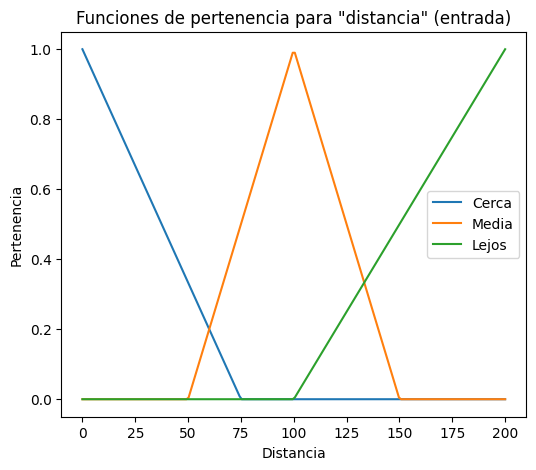

In [3]:
# Definición de funciones de pertenencia para la variable "distancia" en la dirección del objetivo
def close_direction(x):
    return np.maximum(0, 1 - abs(x - 0) / 75)

def mid_direction(x):
    return np.maximum(0, 1 - abs(x - 100) / 50)

def far_direction(x):
    return np.maximum(0, 1 - abs(x - 200) / 100)

# Generación de valores de entrada para "distancia" en la dirección del objetivo
x_distance = np.linspace(0, 200, 200)
x_fuerza = np.linspace(0, 12, 200)

# Creación de una figura para las funciones de pertenencia
fig, ax = plt.subplots(figsize=(6, 5))

# Graficar las funciones de pertenencia para "distancia" en la dirección del objetivo
ax.plot(x_distance, close_direction(x_distance), label='Cerca')
ax.plot(x_distance, mid_direction(x_distance), label='Media')
ax.plot(x_distance, far_direction(x_distance), label='Lejos')
ax.set_xlabel('Distancia')
ax.set_ylabel('Pertenencia')
ax.legend()
ax.set_title('Funciones de pertenencia para "distancia" (entrada)')
plt.show()

#### Simulación de pelota y robot

In [6]:
# Inicialización de pygame
pygame.init()

# Definición de dimensiones de la ventana
WIDTH, HEIGHT = 600, 600

# Definición de colores
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 128, 0)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)

# Creación de la ventana del juego
win = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Robot Soccer")
clock = pygame.time.Clock()

# Clase que representa al robot
class Robot:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.speed = 1

    def move_towards(self, target_x, target_y):
        # Cálculo de la distancia y el ángulo
        dist = np.sqrt((target_x - self.x)**2 + (target_y - self.y)**2)
        angulo = np.arctan2(target_y - self.y, target_x - self.x) * 180 / np.pi
        
        # Evaluación de las funciones de pertenencia
        cerca = close_distance(dist)
        medium = mid_distance(dist)
        lejos = far_distance(dist)
        frente = front_angle(angulo)
        derecha = right_angle(angulo)
        izquierda = left_angle(angulo)
 
        # Lógica difusa para el movimiento del robot
        probabilidad_distancia = 0 if cerca > 0.5 else 1
        frente_y_lejos = frente * probabilidad_distancia
        derecha_y_lejos = derecha * probabilidad_distancia
        izquierda_y_lejos = izquierda * probabilidad_distancia

        numerador = frente_y_lejos * 0 + derecha_y_lejos * 90 + izquierda_y_lejos * (-90)
        denominador = frente_y_lejos + derecha_y_lejos + izquierda_y_lejos

        angulo = 0
        if denominador == 0:
            self.speed = 0
            print("Pelota encontrada! Robot se detiene.\n")
        else:
            angulo = numerador / denominador
            self.speed = 2

        direction = (np.cos(angulo * np.pi / 180), np.sin(angulo * np.pi / 180))

        # Movimiento del robot
        self.x += direction[0] * self.speed
        self.y += direction[1] * self.speed

    def kick_ball(self, ball):
        # Cálculo de la distancia entre la pelota y el objetivo
        dist = np.sqrt((WIDTH - ball.x)**2 + (HEIGHT//2 - ball.y)**2)

        # Evaluación de las funciones de pertenencia
        cerca = close_direction(dist)
        media = mid_direction(dist)
        lejos = far_direction(dist)

        # Definición de la fuerza en función de las pertenencias
        cerca_fuerza = int(cerca * 4)
        media_fuerza = int(media * 6)
        lejos_fuerza = int(lejos * 8)

        nominador = cerca_fuerza + media_fuerza + lejos_fuerza
        denominador = cerca + media + lejos

        if denominador == 0:
            ball.set_speed(0)
        else:
            velocidad = int(nominador / denominador)
            print("Kicked! \nSpeed of the ball:", velocidad)
            ball.set_speed(velocidad)

    def draw(self, win):
        # Dibujo del robot como un rectángulo
        pygame.draw.rect(win, BLACK, (self.x-10, self.y-20, 20, 40))

# Clase que representa la pelota
class Ball:
    def __init(self, x, y):
        self.x = x
        self.y = y
        self.speed = 1

    def set_speed(self, speed):
        self.speed = speed

    def move_towards(self, target_x, target_y):
        direction = (target_x - self.x, target_y - self.y)
        norm = np.sqrt(direction[0]**2 + direction[1]**2)
        
        # Umbral de llegada
        if norm < 10:
            return

        direction = (direction[0] / norm, direction[1] / norm)
        self.x += direction[0] * self.speed
        self.y += direction[1] * self.speed

    def draw(self, win):
        # Dibujo de la pelota como un círculo
        pygame.draw.circle(win, RED, (int(self.x), int(self.y)), 15)

# Función para actualizar la ventana del juego
def redraw_window(robot, ball):
    win.fill(GREEN)

    # Dibujar elementos en la pantalla
    pygame.draw.rect(win, WHITE, (WIDTH-20, HEIGHT//4, 30, HEIGHT//2))
    pygame.draw.rect(win, WHITE, (WIDTH-200, HEIGHT//4-50, 200, HEIGHT//2+100), 5)
    pygame.draw.circle(win, WHITE, (WIDTH-200, HEIGHT//2), 25, 25)

    # Dibujar el robot y la pelota
    robot.draw(win)
    ball.draw(win)
    pygame.display.update()

# Inicialización de variables
ball_kicked = False
run = True
x_robot, y_robot = random.randint(0, WIDTH-300), random.randint(0, HEIGHT)
x_ball, y_ball = random.randint(WIDTH-300, WIDTH-50), random.randint(200, 400)

# Creación de instancias del robot y la pelota
robot = Robot(x_robot, y_robot)
ball = Ball(x_ball, y_ball)

# Bucle principal del juego
while run:
    clock.tick(30)  # Limitamos a 30 FPS
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            run = False

    if robot.speed == 0 and not ball_kicked:
        ball_kicked = True
        robot.kick_ball(ball)

    if ball_kicked:
        ball.move_towards(WIDTH, HEIGHT//2)
    else:
        robot.move_towards(ball.x, ball.y)

    # Actualizar la ventana del juego
    redraw_window(robot, ball)

    if ball.x >= WIDTH - 20:
        print("¡GOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOLLLLLLLLL!")
        run = False

# Salir del juego
pygame.quit()

Pelota encontrada! Robot se detiene.

Kicked! 
Speed of the ball: 5
¡GOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOLLLLLLLLL!
